In [257]:
from prophet import Prophet
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
import prophet
warnings.filterwarnings('ignore')

In [258]:
data=pd.read_csv('univariate_models/multivar.csv', index_col=0, parse_dates=[0])

print(data.shape)
data.head()

(2023, 53)


,iso_code,continent,location,date,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,...,new_deaths_4_week_min,year,season,comparison_with_previous,icu_utilization_ratio,healthcare_strain_index,cumulative_cases_threshold,gdp_stringency_interaction,Holiday,Normal day
24348,BEL,Europe,Belgium,2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,...,NaN,2020,Spring,NaN,NaN,NaN,0,4.739368e+05,0,1
24355,BEL,Europe,Belgium,2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,...,NaN,2020,Spring,0.0,0.000000,0.000000,1,5.925276e+05,0,1
24362,BEL,Europe,Belgium,2020-03-15,1362.0,1046.0,9.0,116.850,89.740,4.547,...,NaN,2020,Spring,9.0,0.080621,4.806915,2,2.172601e+06,0,1
24369,BEL,Europe,Belgium,2020-03-22,4473.0,3111.0,140.0,383.753,266.903,27.969,...,0.0,2020,Spring,131.0,0.495904,30.225532,3,3.475821e+06,0,1
24376,BEL,Europe,Belgium,2020-03-29,12031.0,7558.0,602.0,1032.179,648.426,82.447,...,0.0,2020,Spring,462.0,1.461826,83.617908,4,3.475821e+06,0,1


In [259]:
data=pd.read_csv('univariate_models/multivar.csv')
data = data.drop(columns=['iso_code'])
data['date'] = pd.to_datetime(data['date'])
data = data.rename(columns={'date': 'ds', 'new_deaths': 'y'})
main = ['continent', 'tests_units', 'season', 'location']
data = pd.get_dummies(data, columns=main)
data = data.drop (columns=['new_deaths_1_week_lag', 'new_deaths_2_week_lag',
       'new_deaths_4_week_lag', 'new_deaths_2_week_mean',
       'new_deaths_4_week_mean', 'new_deaths_2_week_std',
       'new_deaths_4_week_std', 'new_deaths_2_week_max',
       'new_deaths_4_week_max', 'new_deaths_2_week_min',
       'new_deaths_4_week_min'])

data = data.set_index('ds')

def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['y']].join(lag1df)
    return df.fillna(0) 
data=process(data)

data = data.drop (columns=[ 'lag1_y'])

train_size = int(len(data) * 0.8)
train=data.iloc[:train_size ] 
test=data.iloc[train_size: ] 
print(train.shape, test.shape)
data.head()

# remove lagged features because the multivariate prohet does not take in lagged feature


#implement process


(16167, 57) (4042, 57)


,y,lag1_Unnamed: 0,lag1_total_cases,lag1_new_cases,lag1_total_cases_per_million,lag1_new_cases_per_million,lag1_icu_patients_per_million,lag1_hosp_patients_per_million,lag1_weekly_icu_admissions_per_million,lag1_weekly_hosp_admissions_per_million,...,lag1_location_Belgium,lag1_location_Chile,lag1_location_Czechia,lag1_location_Estonia,lag1_location_France,lag1_location_Ireland,lag1_location_Israel,lag1_location_Italy,lag1_location_Malaysia,lag1_location_United States
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2020-03-01,0.0,25665.0,4848745.0,0.0,415989.793,0.0,0.000,0.00,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
2020-03-01,0.0,50086.0,5329103.0,0.0,271841.194,0.0,0.000,0.00,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
2020-03-01,0.0,63816.0,0.0,0.0,0.000,0.0,2.287,22.87,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
2020-03-01,0.0,78190.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False


In [260]:
print(train.shape, test.shape)


(16167, 57) (4042, 57)


In [261]:
model = Prophet()
for col in train.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)


model.fit(train.reset_index())


17:45:48 - cmdstanpy - INFO - Chain [1] start processing
17:45:53 - cmdstanpy - INFO - Chain [1] done processing


In [262]:
test_pred = model.predict(test.reset_index()).set_index('ds')
test_pred['yhat'] = np.maximum(test_pred['yhat'], 0) # clamp 
test_pred['yhat']

ds
2023-04-02    0.0
2023-04-02    0.0
2023-04-02    0.0
2023-04-02    0.0
2023-04-02    0.0
             ... 
2024-01-14    0.0
2024-01-14    0.0
2024-01-14    0.0
2024-01-14    0.0
2024-01-14    0.0
Name: yhat, Length: 4042, dtype: float64

In [263]:
test['y']

ds
2023-04-02     24.0
2023-04-02     24.0
2023-04-02     24.0
2023-04-02    181.0
2023-04-02    181.0
              ...  
2024-01-14      0.0
2024-01-14      0.0
2024-01-14      1.0
2024-01-14      1.0
2024-01-14      1.0
Name: y, Length: 4042, dtype: float64

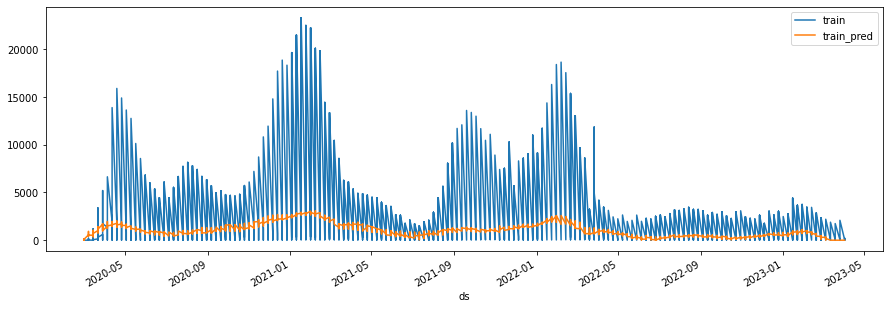

In [264]:
train_pred=model.predict(train.reset_index()).set_index('ds')

train_pred['yhat'] = np.maximum(train_pred['yhat'], 0) # clamp negtaive values
pd.concat([train['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

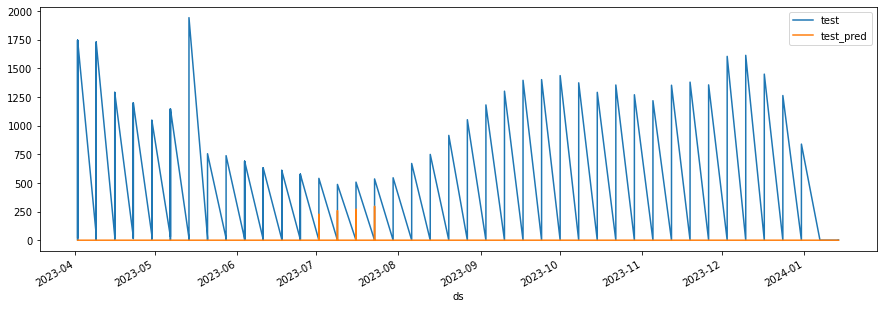

In [265]:
pd.concat([test['y'],test_pred['yhat']],axis = 1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])


In [266]:
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.array(y_true[:-1])
    y_true_insample = np.array(y_true[1:])
    insample_error = np.abs(y_true_insample - naive_forecast)
    # Calculate the forecast errors
    forecast_error = np.abs(y_true - y_pred)
    # Calculate the MASE
    mase = np.mean(forecast_error) / np.mean(insample_error)
    return mase

# Check MAE value
performance_baseline_MAE = mean_absolute_error(test['y'], test_pred['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MASE = mean_absolute_scaled_error(np.array(test['y']), np.array(test_pred['yhat']))
print(f'The MASE for the baseline model is {performance_baseline_MASE}')

The MAE for the baseline model is 138.2916037321461
The MASE for the baseline model is 5.326766217857063


In [267]:
forecast_baseline

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,lag1_year,lag1_year_lower,lag1_year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-02,228.710768,-3667.648643,3132.516349,228.710768,228.710768,-626.545409,-626.545409,-626.545409,-848.498214,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
1,2023-04-02,228.710768,-3539.696060,3052.029277,228.710768,228.710768,-475.158280,-475.158280,-475.158280,-697.111085,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
2,2023-04-02,228.710768,-3701.289513,3144.980750,228.710768,228.710768,-337.815254,-337.815254,-337.815254,-559.768059,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
3,2023-04-02,228.710768,-3766.512994,3028.800703,228.710768,228.710768,-626.545409,-626.545409,-626.545409,-848.498214,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
4,2023-04-02,228.710768,-3357.279266,3125.064451,228.710768,228.710768,-392.672847,-392.672847,-392.672847,-614.625652,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,2024-01-14,-364.133463,-4100.194580,2901.606703,-966.285374,198.268835,-72.517778,-72.517778,-72.517778,-622.810537,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
4038,2024-01-14,-364.133463,-3656.376881,3399.953562,-966.523120,198.162791,243.953749,243.953749,243.953749,-306.339010,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
4039,2024-01-14,-364.133463,-3608.398351,3267.569654,-966.760866,198.056748,139.126845,139.126845,139.126845,-411.165914,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
4040,2024-01-14,-364.133463,-3780.852770,3164.035543,-966.975051,197.950704,-72.517778,-72.517778,-72.517778,-622.810537,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0


In [268]:
test = test.reset_index()
forecast_baseline['yhat'] = np.maximum(forecast_baseline['yhat'], 0)
d =pd.concat([test['y'],forecast_baseline['yhat']], axis = 1)


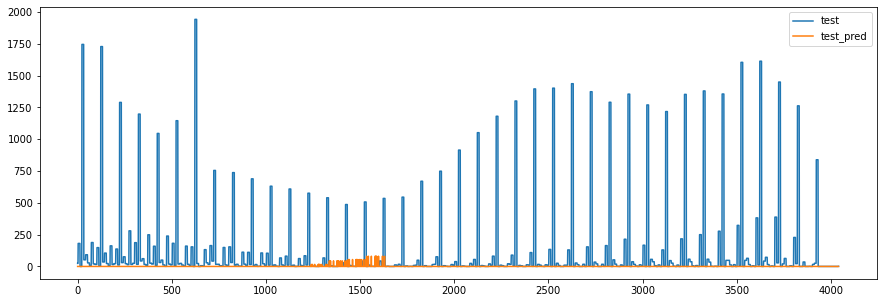

In [269]:

d.plot(figsize=(15,5))
plt.legend(['test','test_pred'])

In [270]:
d

,y,yhat
0,24.0,0.0
1,24.0,0.0
2,24.0,0.0
3,181.0,0.0
4,181.0,0.0
...,...,...
4037,0.0,0.0
4038,0.0,0.0
4039,1.0,0.0
4040,1.0,0.0


In [ ]:
test = test.reset_index()
forecast_baseline['yhat'] = np.maximum(forecast_baseline['yhat'], 0)
d =pd.concat([test['y'],forecast_baseline['yhat']], axis = 1)

In [271]:
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.array(y_true[:-1])
    y_true_insample = np.array(y_true[1:])
    insample_error = np.abs(y_true_insample - naive_forecast)
    # Calculate the forecast errors
    forecast_error = np.abs(y_true - y_pred)
    # Calculate the MASE
    mase = np.mean(forecast_error) / np.mean(insample_error)
    return mase

# Check MAE value
performance_baseline_MAE = mean_absolute_error(test['y'], forecast_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MASE = mean_absolute_scaled_error(np.array(test['y']), np.array(forecast_baseline['yhat']))
print(f'The MASE for the baseline model is {performance_baseline_MASE}')

The MAE for the baseline model is 136.60400505525178
The MASE for the baseline model is 5.2617626791115555


In [272]:
forecast_baseline

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,lag1_year,lag1_year_lower,lag1_year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-02,228.710768,-3667.648643,3132.516349,228.710768,228.710768,-626.545409,-626.545409,-626.545409,-848.498214,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
1,2023-04-02,228.710768,-3539.696060,3052.029277,228.710768,228.710768,-475.158280,-475.158280,-475.158280,-697.111085,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
2,2023-04-02,228.710768,-3701.289513,3144.980750,228.710768,228.710768,-337.815254,-337.815254,-337.815254,-559.768059,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
3,2023-04-02,228.710768,-3766.512994,3028.800703,228.710768,228.710768,-626.545409,-626.545409,-626.545409,-848.498214,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
4,2023-04-02,228.710768,-3357.279266,3125.064451,228.710768,228.710768,-392.672847,-392.672847,-392.672847,-614.625652,...,-31.871073,-31.871073,-31.871073,221.952805,221.952805,221.952805,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,2024-01-14,-364.133463,-4100.194580,2901.606703,-966.285374,198.268835,-72.517778,-72.517778,-72.517778,-622.810537,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
4038,2024-01-14,-364.133463,-3656.376881,3399.953562,-966.523120,198.162791,243.953749,243.953749,243.953749,-306.339010,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
4039,2024-01-14,-364.133463,-3608.398351,3267.569654,-966.760866,198.056748,139.126845,139.126845,139.126845,-411.165914,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
4040,2024-01-14,-364.133463,-3780.852770,3164.035543,-966.975051,197.950704,-72.517778,-72.517778,-72.517778,-622.810537,...,-42.399467,-42.399467,-42.399467,550.292759,550.292759,550.292759,0.0,0.0,0.0,0.0
